# Physical scene understanding lab

This lab introduces concepts and tools for building probabilistic models of intuitive physics. It focuses on inferring physical object properties (mass, bounciness) from sequentially observed video input.

<div class="alert alert-info" markdown="1">
    <strong> Note on installing necessary packages </strong>

We installed `pybullet` (see below for what it is) using `Conda.jl`. This is for your reference if you wish to install on your local environment. For the purposes of the class and the lab, you can safely skip this codeblock as it is already run within the class Apptainer container. 
    
```julia
using Pkg
Pkg.activate("psyc261")
Pkg.add("Conda")
using Conda
Conda.add("pybullet")

```
    
</div>



In [1]:
using Gen;
using Pkg;
Pkg.activate("psyc261")

  Activating project at `~/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/psyc261`


## Part 0: Setup for this lab

Since this lab uses some extra dependencies, please make sure to follow these instructions carefully. 

We will use [pybullet](https://pybullet.org/wordpress/), a real time physics engine, under the hood to create physics-based temporal generative models.The `PyCall` package should take care of this for you in `pyimport`. 

In [2]:
using PyCall
pb = pyimport("pybullet")

pybullet build time: Oct 14 2023 16:04:51


PyObject <module 'pybullet' from '/Users/john/.local/conda/lib/julia/conda/3/aarch64/lib/python3.10/site-packages/pybullet.cpython-310-darwin.so'>

### First time installations

With this, we can install several Julia packages. The first two, which are form the CNCL github repo, provide functionality for inference over physical scenes. 

In [3]:
Pkg.add(url="https://github.com/CNCLgithub/PhySMC.git");
Pkg.add(url="https://github.com/CNCLgithub/PhyBullet.git");
Pkg.add("Accessors");
Pkg.add("Distributions");

    Updating git-repo `https://github.com/CNCLgithub/PhySMC.git`
   Resolving package versions...
  No Changes to `~/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/psyc261/Project.toml`
  No Changes to `~/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/psyc261/Manifest.toml`
    Updating git-repo `https://github.com/CNCLgithub/PhyBullet.git`
   Resolving package versions...
  No Changes to `~/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/psyc261/Project.toml`
  No Changes to `~/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `~/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/psyc261/Project.toml`
  No Changes to `~/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/psyc261/Manifest.toml`
   Resolving package versions...
  No Changes to `~/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/psyc261/Project.toml`
  No Changes to `~/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/ps

In [4]:
using PhySMC;
using PhyBullet;
# the following package allows us to more nicely/easily update contents of 
# structs that contain object state information
using Accessors; 
using Distributions;

## Part 1: The task: inference by reversing physical simulation

Introduced by Battaglia et al. (2013), the idea of a "physics engine in the mind" refers to a general schema where the mind might use runnable mental models, akin to a physical simulator in a video game engine, to infer "physical hypotheses" that can explain the contents of the kinds of dynamic scenes we encounter in our visual environments. This idea can be made concrete in certain domains to explore its predictions and to empirically evaluate it against behavioral or neural measurmenets.

Here, we explore an implementation a model that uses the [`pybullet`](https://pybullet.org/) physics engine to simulate the trajectory of a ball given different hypotheses about it's [coefficient of restitution](https://en.wikipedia.org/wiki/Coefficient_of_restitution) and mass. We will also explore inference procedures, such as [particle filters](https://en.wikipedia.org/wiki/Particle_filter) that leverage the sequential nature of the underlying world model to efficiently update physical hypotheses. 

Specifically, we will observe a sequence of the positions of a falling and bouncing ball, and based on that, infer its mass and bounciness. 

## Part 2: Physical Generative Model

The generative model (`model`) consists of a hypothesis over objects in the scene and uses the `bullet` physics engine to produce a sequence of predictions about the object state across time.

This part will codify the following diagram in a generative model -- we will remain at an abstract level not yet thinking about exactly what we are simulating. We will make things concrete in Part 3.

![Physics Graphical Model](media/phys_gm.png)

The generative model is split up into several small generative functions: 

1) `prior` samples new latents (mass and restitution) defining the initial world state
2) `kernel` simulates `T` steps into the future, generating world states for each step
3) `observe` generates noisy observations over object positions (in $\mathcal{R}^3$) for a given state

In [5]:
# a helper function to update the state contained in a struct called RigidBodyLatents
# Notice that RigidBodyLatents contains all of the latent variables that we wish to make inferences about
function update_latents(ls::RigidBodyLatents, mass::Float64, res::Float64)
    RigidBodyLatents(setproperties(ls.data;
                           mass=mass,
                           restitution=res))
end

update_latents (generic function with 1 method)

The prior is defined over the mass and restitution of an object (that will fall from a height and bounce). Notice that these latents are stored in the `RigidBodyLatents` struct.

In [6]:
@gen function prior(ls::RigidBodyLatents)
    mass = @trace(gamma(1.2, 10.), :mass)
    res = @trace(uniform(0, 1), :restitution)
    new_latents = update_latents(ls, mass, res)
    return new_latents
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[RigidBodyLatents], false, Union{Nothing, Some{Any}}[nothing], var"##prior#292", Bool[0], false)

The function `observe` defines our likelihood function. Given the current physical state, it emits noisy positions in space (xyz) as the observation space.

Notice that this model *assumes* a non-visual observation space &ndash; the kinematic state (in this case, just the position) of an object is something perception would need to additionally infer to make physical inferences. 

<div class="alert alert-warning" markdown="1">
    
**Exercise:** Think about (do not implement; or implement on your own time later) how you would extend this model to make contact with an observation space that is more sensory in nature (pixels etc.). 
</div>

In [7]:
@gen function observe(k::RigidBodyState)
    pos = k.position # XYZ position
    # add noise to position of each object (via the Map combinator)
    # however, notice that the example we will work out will include only 1 object
    obs = @trace(broadcasted_normal(pos, 0.1), :kinematics)
    return obs
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[RigidBodyState], false, Union{Nothing, Some{Any}}[nothing], var"##observe#293", Bool[0], false)

Now let's move to the kernel of the generative model as well as the use of th Unfold combinator to realize a temporal generative model. Notice that the kernel makes a call to the physics engine to step the simulation one time step forward, using `PhySMC.step(...)`. This implements temporal dynamics in the generative model, the horizontal arrow from the figure above. 

(In brief, the package `PhySMC` provides an appropriate abstraction for interfacing probabilistic programming and physics engine states. Read the [PhySMC ReadMe](https://github.com/CNCLgithub/PhySMC/blob/master/README.md) for me.)  

The return value of this call, `next_state` is a kinematic state (position, velocity, orientation) of a rigid body (i.e., the object we are simulating).

In [8]:
@gen function kernel(t::Int, prev_state::BulletState, sim::BulletSim)
    # use of PhySMC.step to step the simulation forward one time step
    next_state::BulletState = PhySMC.step(sim, prev_state)
    # `next_state.kinematics = [RigidBodyState]` G
    obs = @trace(Gen.Map(observe)(next_state.kinematics), :observe)
    return next_state
end

@gen function model(T::Int, sim::BulletSim, template::BulletState)
    # distribution over mass and restitution for objects from the prior
    latents = @trace(Gen.Map(prior)(template.latents), :prior)
    init_state = Accessors.setproperties(template; latents=latents)
    # simulate `T` timesteps
    states = @trace(Gen.Unfold(kernel)(T, init_state, sim), :kernel)
    return states
end;

## Part 3: Defining a physical scene

To make the `model` concrete in a physical scenario, all we need to do is to initialize a scene configuration, which can then be simulated forward.

Here, we will use `PhySMC` and `PhyBullet` to initialize a simple scene: a table and a ball above its center. 

In [9]:
function simple_scene(mass::Float64=1.0, restitution::Float64=0.9)
    # `pb` is the `pybullet` python package
    # initialize a physics server in pybullet
    client = @pycall pb.connect(pb.DIRECT)::Int64
    # gotta set the gravity
    pb.setGravity(0,0,-10; physicsClientId=client)

    # add a table
    dims = [1.0, 1.0, 0.1] # in meters
    col_id = pb.createCollisionShape(pb.GEOM_BOX,
                                     halfExtents=dims,
                                     physicsClientId=client)
    obj_id = pb.createMultiBody(baseCollisionShapeIndex=col_id,
                                basePosition=[0., 0., -0.1],
                                physicsClientId=client)
    pb.changeDynamics(obj_id,
                      -1;
                      mass=0., # 0 mass means this object does not move (it's stationary)
                      restitution=0.9, # some is necessary; we could learn or infer this parameter
                      physicsClientId=client)


    # add a ball
    bcol_id = pb.createCollisionShape(pb.GEOM_SPHERE,
                                      radius=0.1,
                                      physicsClientId=client)
    bobj_id = pb.createMultiBody(baseCollisionShapeIndex=bcol_id,
                                 basePosition=[0., 0., 1.0],
                                 physicsClientId=client)
    pb.changeDynamics(bobj_id,
                      -1;
                      mass=mass,
                      restitution=restitution,
                      physicsClientId=client)

    (client, bobj_id)
end

# start with a ball above a table
client, ball_id = simple_scene()
# configure simulator with the provided
# client id
sim = BulletSim(; client=client)
# This is the object of interest in the scene
# (the table is static)
ball = RigidBody(ball_id)
# Retrieve the default latents for the ball
# as well as its initial positions
# Note: alternative latents will be suggested by the `prior`
init_state = BulletState(sim, [ball])
# arguments for `model`
gargs = (60, # number of steps (total duration 1s)
         sim,
         init_state);

Here, you will see several new expressions:

- `BulletSim`
- `BulletState`
- `RigidBody`

We can inspect their docstrings for more info.

In [10]:
@doc BulletSim

Parameters for using the Bullet physics engine

```julia
struct BulletSim <: PhySim
```

---

  * `client::Int64`: Client id for pybullet
  * `step_dur::Float64`: Amount of time between `forward_steps` (default=16.7ms) Default: 1 / 60
  * `pb_timestep::Float64`: Timestep duration of bullet engine (default: 4.2ms) Default: 1 / 240


In [11]:
@doc BulletState

State for `BulletSim`

```julia
struct BulletState <: PhyState{BulletSim}
```

---

  * `elements::AbstractVector{BulletElement}`
  * `latents::AbstractVector{BulletElemLatents}`
  * `kinematics::AbstractVector{BulletElemState}`


In [12]:
@doc RigidBody

A rigid body in `BulletSim`

```julia
struct RigidBody <: BulletElement
```

Consists of a single base collision object.

---

  * `object_id::Int64`: The `bodyUniqueId` of the base object


With the simulator configured to start with the template scene, we can go ahead and run the generative model.

<div class="alert alert-info" markdown="1">
    
Note how the different physical and kinematic properties of the objects are referenced in a generic way in `model`. This allows us to start with more complex scenes than the one we use in this example. 
</div>

In [13]:
# execute `model`
trace, _ = generate(model, gargs);
get_choices(trace)

│
├── :prior
│   │
│   └── 1
│       │
│       ├── :restitution : 0.23010395736866118
│       │
│       └── :mass : 24.451574692736486
│
└── :kernel
    │
    ├── 1
    │   │
    │   └── :observe
    │       │
    │       └── 1
    │           │
    │           └── :kinematics : [0.03503030376015352, 0.006145481265093398, 1.073694834179621]
    │
    ├── 2
    │   │
    │   └── :observe
    │       │
    │       └── 1
    │           │
    │           └── :kinematics : [-0.043811163498111545, 0.13023495844514635, 0.9245318921541534]
    │
    ├── 3
    │   │
    │   └── :observe
    │       │
    │       └── 1
    │           │
    │           └── :kinematics : [-0.08523639465808913, -0.05272438972501692, 0.9554793835782603]
    │
    ├── 4
    │   │
    │   └── :observe
    │       │
    │       └── 1
    │           │
    │           └── :kinematics : [0.09462396394357511, -0.04474023058733561, 0.7842115359100832]
    │
    ├── 5
    │   │
    │   └── :observe
    │       │
    │    

That was anti-climactic. Let's also create a helper function to visualize the height of the ball as a function of time

> `pybullet` comes with a debug gui to visualize simulations but this would require a complicated setup for jupyter notebooks.

In [14]:
using Plots;

@userplot SimPlot
@recipe function f(cp::SimPlot)
    z, t = cp.args
    cs = size(z, 1)
    k = 10
    inds = (max(1, t-k):t)
    n = length(inds)
    linewidth --> range(0, 10, length = n)
    seriesalpha --> range(0, 1, length = n)
    xguide --> "time"
    yguide --> "height of ball (z)"
    ylims --> (0, 1.0)
    xlims --> (1, 60)
    label --> false
    inds, z[inds, :]
end

function get_zs(trace::Gen.Trace)
    t, _... = get_args(trace)
    states = get_retval(trace)
    zs = Vector{Float64}(undef, t)
    for i = 1:t
        zs[i] = states[i].kinematics[1].position[3]
    end
    return zs
end

function animate_trace(trace::Gen.Trace; label = "trace")
    t = first(get_args(trace))
    zs = reshape(get_zs(trace), (t, 1))
    anim = @animate for i = 2:t
        simplot(zs, i, label = label)
    end
end;

[ Info: Saved animation to /Users/john/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/tmp.gif


Plots.AnimatedGif("/Users/john/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/tmp.gif")
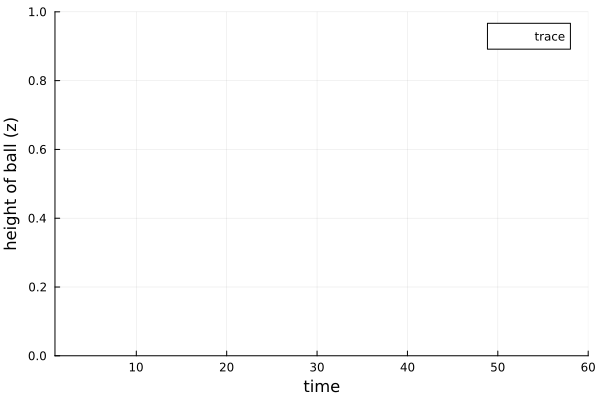

In [15]:
anim = animate_trace(trace)
gif(anim, fps = 24)

By repeatedly running `Gen.generate` on `model`, we draw a variety of samples from the prior and thus traces. Here, we visualize how traces that sample a range of physical properties for the ball lead to different timecourses. 

In [16]:
traces = [first(generate(model, gargs)) for _=1:5];

In [17]:
function animate_traces(traces::Vector{<:Gen.Trace})
    n = length(traces)
    zzs = reduce(hcat, map(get_zs, traces))
    t = size(zzs, 1)
    anim = @animate for i=2:t
        simplot(zzs, i)
    end
end

animate_traces (generic function with 1 method)

[ Info: Saved animation to /Users/john/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/tmp.gif


Plots.AnimatedGif("/Users/john/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/tmp.gif")
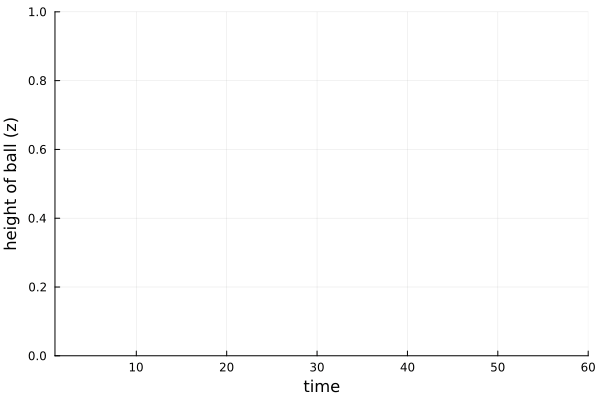

In [18]:
gif(animate_traces(traces), fps=24)

Note how restitution, and not mass, has any effect on the resulting trajectory. 

## Part 4: Inference over dynamic scenes

Now that we have implemented a generative model over this simple scene, we can perform inferences in it given a set of observed positions

Let's start with generating a synthetic observation.

[ Info: Saved animation to /Users/john/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/tmp.gif


Plots.AnimatedGif("/Users/john/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/tmp.gif")
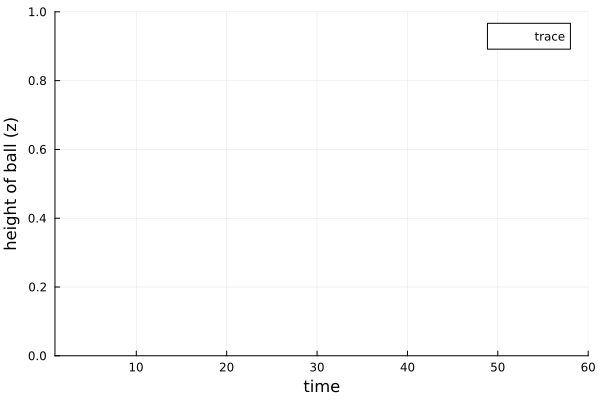

In [19]:
# First, let's generate a scene with a specific mass and restitution 
# Our goal is to generate a simulated observation that we can work with
gt_latents = choicemap(
    (:prior => 1 => :restitution, 0.8), 
    (:prior => 1 => :mass, 1.0)
)
gt = first(generate(model, gargs, gt_latents));
gt_choices = get_choices(gt)

t = gargs[1]

# one set of observations per time step
# (notice that these do not contain gt latents)
observations = Vector{Gen.ChoiceMap}(undef, t)
for i = 1:t
    cm = choicemap()
    addr = :kernel => i => :observe
    set_submap!(cm, addr, get_submap(gt_choices, addr))
    observations[i] = cm
end

gif(animate_trace(gt), fps=24)

Here, we define the inference procedure: a particle filter 

In [20]:
include("truncatednorm.jl");

# this proposal function implements a truncated random walk for mass and restitution
@gen function proposal(tr::Gen.Trace)
    # HINT: https://www.gen.dev/tutorials/iterative-inference/tutorial#mcmc-2
    #
    # get previous values from `tr`
    choices = get_choices(tr)
    prev_mass = choices[:prior => 1 => :mass]
    prev_res  = choices[:prior => 1 => :restitution]
    
    # sample new values conditioned on the old ones
    # (Note: values are truncated to avoid issues with simulation)
    mass = {:prior => 1 => :mass} ~ trunc_norm(prev_mass, .1, 0., Inf)
    restitution = {:prior => 1 => :restitution} ~ trunc_norm(prev_res, .1, 0., 1.)
    
    # the return of this function is not
    # neccessary but could be useful
    # for debugging.
    return (mass, restitution)
end

"""
    inference_procedure

Performs particle filter inference with rejuvenation.
"""
function inference_procedure(gm_args::Tuple,
                             obs::Vector{Gen.ChoiceMap},
                             particles::Int=20)
    get_args(t) = (t, gm_args[2:3]...)

    # initialize particle filter
    state = Gen.initialize_particle_filter(model, get_args(0), EmptyChoiceMap(), particles)
    argdiffs = (UnknownChange(), NoChange(), NoChange()) # only the first argument will change
    
    # Then increment through each observation step
    for (t, o) = enumerate(obs)
        # apply a rejuvenation move to each particle
        step_time = @elapsed begin
            for i=1:particles
                state.traces[i], _ = mh(state.traces[i], proposal, ())
            end
        
            Gen.maybe_resample!(state, ess_threshold=particles/2) 
            Gen.particle_filter_step!(state, get_args(t), argdiffs, o)
        end
    end

    return state.traces
    # return the "unweighted" set of traces after t steps
    # return Gen.sample_unweighted_traces(state, particles)
end;

We can now apply this inference procedure to infer the latents in our model that will best explain the set of observed positions. 

In [21]:
result = inference_procedure(gargs, observations); #should take a few seconds

Visualizing the predictions of these traces, we can see that the inference procedure can generally re-create the ground truth trajectory. 

[ Info: Saved animation to /Users/john/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/tmp.gif


Plots.AnimatedGif("/Users/john/10-projects/10.02-algorithms-of-the-mind/labs/lab-06/tmp.gif")
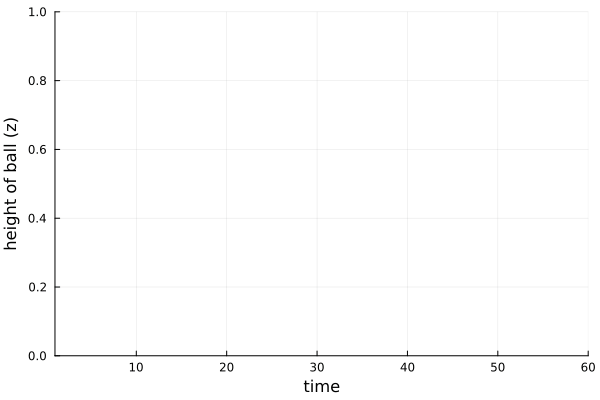

In [22]:
gif(animate_traces(result), fps=24)

By plotting the distribution of inferred latents, we see that indeed restitution converges to the ground truth, while mass varies arbitrarily.

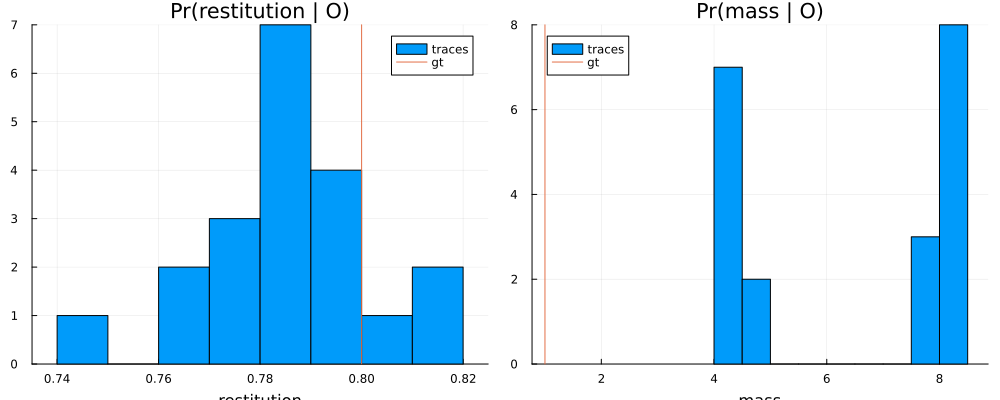

In [23]:
function get_latents(traces::Vector{<:Gen.Trace})
    n = length(traces)
    mass = Vector{Float64}(undef, n)
    restitution = Vector{Float64}(undef, n)
    for i = 1:n
        mass[i] = traces[i][:prior => 1 => :mass]
        restitution[i] = traces[i][:prior => 1 => :restitution]
    end
    (mass, restitution)
end

function plot_latents(traces::Vector{<:Gen.Trace})
    mass, restitution = get_latents(traces)
    res_plt = histogram(
        restitution, title="Pr(restitution | O)", 
        xlabel="restitution", bins=10, label="traces"
    )
    vline!(res_plt, [0.8], label = "gt") 
    mass_plt = histogram(
        mass, title="Pr(mass | O)",
        xlabel="mass", bins=10, label="traces"
    )
    vline!(mass_plt, [1.0], label = "gt") 
    return plot(res_plt, mass_plt,size=(1000,400))
end

plot_latents(result)